In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split

In [2]:
dataset = torchvision.datasets.CIFAR10(root='data/',download=True,transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4,padding_mode='reflect'), # augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # CxHxW
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

test_dataset = torchvision.datasets.CIFAR10(root='data/',train = False,download=True,transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4,padding_mode='reflect'), # augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # CxHxW
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
val_ratio = 0.2
train_dataset, val_dataset = random_split(dataset,[int((1-val_ratio)*len(dataset)), int(val_ratio*len(dataset))])
batch_size =  32 #higher batch size is better
train_dl = DataLoader(train_dataset,batch_size,shuffle=True,pin_memory=True)
val_dl = DataLoader(val_dataset,batch_size,shuffle=True,pin_memory=True)
test_dl = DataLoader(test_dataset,batch_size,pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


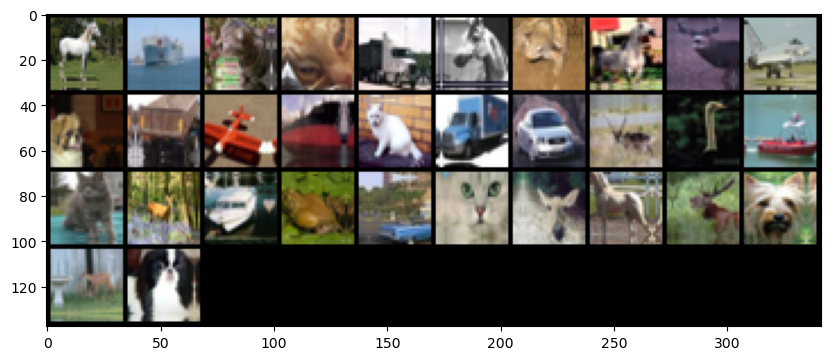

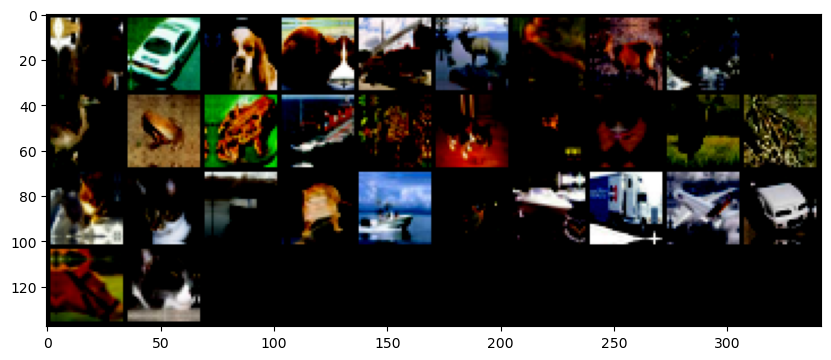

In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def denormalize(images,means,std_div):
  means = torch.tensor(means).reshape(1,3,1,1)
  std_div = torch.tensor(std_div).reshape(1,3,1,1)
  return images*std_div + means

def show_preview(dl,normalized):
  for images,labels in dl:
    fig, ax = plt.subplots(figsize=(10,10))
    if(normalized):
      images = denormalize(images,(0.5,0.5,0.5),(0.5,0.5,0.5))
    ax.imshow(make_grid(images,10).permute(1,2,0)) #H,W,C
    break
show_preview(train_dl,1)
show_preview(train_dl,0)

#they appear dark because we had applied normalization

In [5]:
def get_default_devices():
  return torch.device("cuda").type if torch.cuda.is_available() else torch.device("cpu")

def to_device(data,device):
  if(isinstance(data,(list,tuple))):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)
  #non blocking means you dont want to block execution of code when transferring code

class DeviceDataLoader():
  ''' wrapper around dataloaders to transfer batches to specified devices'''
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
  def __len__(self):
    return len(self.dl)

device = get_default_devices()
train_dl = DeviceDataLoader(train_dl,device)
test_dl = DeviceDataLoader(test_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

### Network architecture

resnets: residual blocks
inception
mobilenet

model = ResnetX(in_channels,num_classes)
logits = model(images)

In [8]:
from typing import OrderedDict
import torch.nn as nn
import torch.nn.functional as F


def conv_block(in_channels,out_channels,use_pool=False):
  layers = [nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels), #skewness doesnt develop in some particular channel
            nn.ReLU(inplace=True)]
  if(use_pool):
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResnetX(nn.Module):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    self.conv1 = conv_block(in_channels,64)
    self.conv2 = conv_block(64,128,use_pool=True)
    # question: how can 1x1 convolution do the same thing ?
    self.res1 = nn.Sequential(OrderedDict([("conv1 res 1",conv_block(128,128)),("conv2 res 1",conv_block(128,128))])) # Pass key-value pairs as a single list
    self.conv3 = conv_block(128,256,use_pool=True)
    self.conv4 = conv_block(256,512,use_pool=True)
    self.res2 = nn.Sequential(conv_block(512,512),conv_block(512,512))
    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2), #for good generalization
                                    nn.Linear(512,num_classes))
  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    # why not add x ? why add out?
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out


In [9]:
model = ResnetX(3,10)
# model
# list(model.parameters())

In [10]:
!pip install torchview

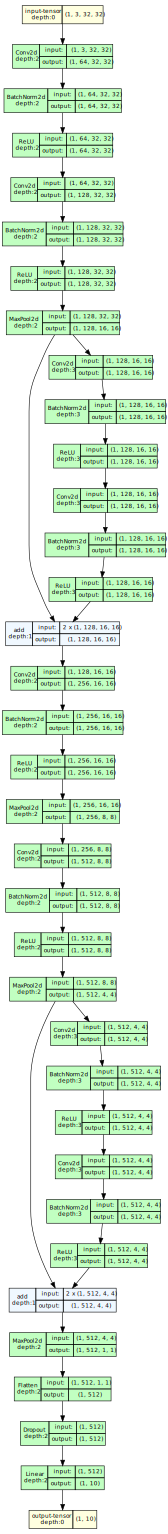

In [11]:
from torchview import draw_graph
model_graph = draw_graph(model, torch.zeros(1, 3, 32, 32))
model_graph.visual_graph

### Training the network

In [12]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [13]:
def accuracy(output, labels):
    predClassId = torch.argmax(output, dim=1)
    return torch.tensor(torch.sum(predClassId == labels).item() / len(output))

def evaluate(model, dl, loss_func):
    model.eval()
    with torch.no_grad():
        batch_losses, batch_accs = [], []

        for images, labels in dl:
            out = model(images)
            loss = loss_func(out, labels)
            batch_losses.append(loss)

            # Calculate accuracy
            acc = accuracy(out, labels)
            batch_accs.append(acc)

        val_loss = torch.stack(batch_losses).mean().item()
        val_acc = torch.stack(batch_accs).mean().item()
        return val_loss, val_acc

def train(model, train_dl, val_dl, epochs, max_lr, loss_function, optim):
    optimizer = optim(model.parameters(), max_lr)
    schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    early_stopper = EarlyStopper(patience=3, min_delta=10)

    results = []

    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []

        for images, labels in train_dl:  # for every batch
            optimizer.zero_grad()
            out = model(images)
            loss = loss_function(out, labels)
            train_loss.append(loss)
            loss.backward()  # delta loss/delta_model_parameters
            optimizer.step()
            lrs.append(optimizer.param_groups[0]['lr'])
            schedular.step()

        epoch_train_loss = torch.stack(train_loss).mean().item()

        # Evaluate on validation data
        val_loss, val_acc = evaluate(model, val_dl, loss_function)
        if early_stopper.early_stop(val_loss):             
            break

        # Store results
        results.append({'avg_train_loss': epoch_train_loss, 'avg_val_loss': val_loss, 'avg_val_acc': val_acc, 'lrs': lrs})

        # Print progress for each epoch
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Training Loss: {epoch_train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}\n")

    return results


In [14]:
model = to_device(model,device)
epochs = 30
max_lr = 1e-2
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam

In [ ]:
results = train(model,train_dl,val_dl,epochs,max_lr,loss_func,optim)

Epoch [1/30]
Training Loss: 1.4085
Validation Loss: 1.0351
Validation Accuracy: 0.6355

Epoch [2/30]
Training Loss: 1.0178
Validation Loss: 0.9824
Validation Accuracy: 0.6673

Epoch [3/30]
Training Loss: 0.9267
Validation Loss: 1.0722
Validation Accuracy: 0.6760

Epoch [4/30]
Training Loss: 0.7853
Validation Loss: 0.6854
Validation Accuracy: 0.7641

Epoch [5/30]
Training Loss: 0.6830
Validation Loss: 0.6919
Validation Accuracy: 0.7665

Epoch [6/30]
Training Loss: 0.6564
Validation Loss: 0.6625
Validation Accuracy: 0.7751

Epoch [7/30]
Training Loss: 0.6378
Validation Loss: 0.6591
Validation Accuracy: 0.7772

Epoch [8/30]
Training Loss: 0.6193
Validation Loss: 0.5760
Validation Accuracy: 0.8095

Epoch [9/30]
Training Loss: 0.5920
Validation Loss: 0.5915
Validation Accuracy: 0.7941

Epoch [10/30]
Training Loss: 0.5522
Validation Loss: 0.6429
Validation Accuracy: 0.8038

Epoch [11/30]
Training Loss: 0.5195
Validation Loss: 0.5239
Validation Accuracy: 0.8270

Epoch [12/30]
Training Loss: 0

In [ ]:
import matplotlib.pyplot as plt

def plot(results, pairs):
    fig, axes = plt.subplots(len(pairs), figsize=(10, 10))  # Adjust height for multiple plots
    for i, pair in enumerate(pairs):
        for title, graphs in pair.items():
            axes[i].set_title = title
            axes[i].legend = graphs
            for graph in graphs:
                axes[i].plot([result[graph] for result in results],".-")

# Example input
plot(results, [{"Accuracies vs epochs": ["avg_val_acc"]},
               {"Losses vs epochs": ["avg_train_loss", "avg_val_loss"]},
               {"Learning rate vs Batches": ["lrs"]}])


In [ ]:
_ , val_acc = evaluate(model,test_dl,loss_func)
print(val_acc)